## SNN assignment3: Utilizing Hyperdimensional Computing
### Name: Hao wan, G-number: G01507853

## Part 1: Exploration of VSA

In [ ]:
pip install torch-hd

In [1]:
import torchhd
print(torchhd.__version__)

5.7.1


In [5]:
import numpy as np
import pandas as pd
import torch
import torchhd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load the Balance Scale Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data"
column_names = ["Class", "Left-Weight", "Left-Distance", "Right-Weight", "Right-Distance"]
data = pd.read_csv(url, names=column_names)

features = data.iloc[:, 1:].values.astype(np.int8)  # Shape: (n_samples, 4)
labels = data.iloc[:, 0].values  # Shape: (n_samples,)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  # L=0, B=1, R=2

dataset = []
for features_row, label in zip(features, labels): 
    dataset.append((tuple(features_row), label))


In [6]:
num_features = 4  # Left-Weight, Left-Distance, Right-Weight, Right-Distance
feature_cardinality = 5  # Each feature 1, 2, 3, 4, 5
num_classes = 3  # Balance, Left, Right
dimensions = 10000  # dimension size

basis_vectors = torchhd.random(num_features * feature_cardinality, dimensions)

# Split into features
feature_vectors = {
    f: {
        v: basis_vectors[f * feature_cardinality + v - 1]
        for v in range(1, feature_cardinality + 1)
    }
    for f in range(num_features)
}

def encode_sample(sample):
    lw, ld, rw, rd = sample
    
    hv_lw = feature_vectors[0][lw]
    hv_ld = feature_vectors[1][ld]
    hv_rw = feature_vectors[2][rw]
    hv_rd = feature_vectors[3][rd]
    
    # Bind the features together
    sample_hv = hv_lw * hv_ld * hv_rw * hv_rd 
    
    return sample_hv

def create_class_prototypes(dataset):
    
    class_hypervectors = {
        'L': torch.zeros(dimensions),
        'B': torch.zeros(dimensions),
        'R': torch.zeros(dimensions)
    }
    class_counts = {'L': 0, 'B': 0, 'R': 0}
    
    for sample, label in dataset:
        sample_hv = encode_sample(sample)
        class_hypervectors[label] += sample_hv 
        class_counts[label] += 1
    
    for label in class_hypervectors:
        class_hypervectors[label] = torch.sign(class_hypervectors[label])
    
    return class_hypervectors

class_prototypes = create_class_prototypes(dataset)

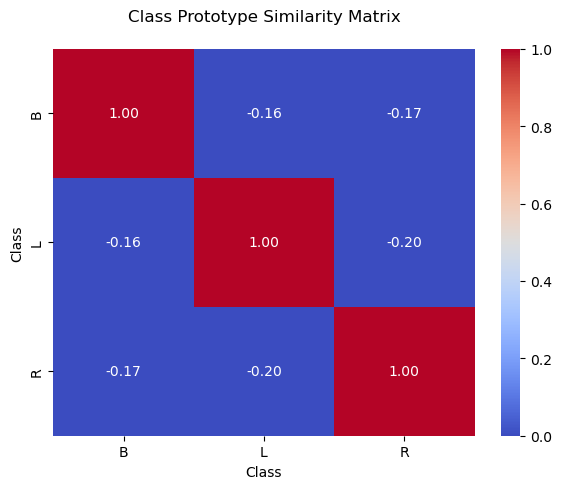

In [14]:
# Convert to tensor for batch processing
prototypes_tensor = torch.stack([
    class_prototypes['B'],
    class_prototypes['L'],
    class_prototypes['R']
])

similarity_matrix = torchhd.cosine_similarity(
    prototypes_tensor.unsqueeze(1),  
    prototypes_tensor.unsqueeze(0)  
).squeeze()

plt.figure(figsize=(6, 5))
sns.heatmap(
    similarity_matrix.numpy(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=['B', 'L', 'R'],
    yticklabels=['B', 'L', 'R']
)

plt.title("Class Prototype Similarity Matrix", pad=20)
plt.xlabel("Class")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

In [1]:
import torch
import torchhd
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

DIMENSIONS = 10000
LEARNING_RATE = 0.01
EPOCHS = 100
BATCH_SIZE = 32

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
data = pd.read_csv(url, names=["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"])

data_encoded = pd.get_dummies(data, columns=data.columns[:-1])
le = LabelEncoder()
data_encoded["class"] = le.fit_transform(data["class"])

X_train, X_test, y_train, y_test = train_test_split(
    data_encoded.drop("class", axis=1).values,
    data_encoded["class"].values,
    test_size=0.2,
    random_state=42
)

class VSAClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.dim = DIMENSIONS
        
        self.embeddings = nn.Linear(input_size, self.dim, bias=False)
        
        self.prototypes = nn.Parameter(torch.randn(num_classes, self.dim))
        
    def forward(self, x):
        x = self.embeddings(x.float())
        
        x = F.normalize(x, p=2, dim=-1)
        prototypes = F.normalize(self.prototypes, p=2, dim=-1)
        
        return torch.mm(x, prototypes.t())

model = VSAClassifier(X_train.shape[1], len(le.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            train_preds = torch.argmax(outputs, dim=1)
            train_acc = accuracy_score(y_train_t, train_preds)
            
            test_outputs = model(X_test_t)
            test_preds = torch.argmax(test_outputs, dim=1)
            test_acc = accuracy_score(y_test, test_preds)
            
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_t)
    test_preds = torch.argmax(test_outputs, dim=1)
    final_acc = accuracy_score(y_test, test_preds)
    print(f"\nFinal Test Accuracy: {final_acc:.2%}")

Epoch  10 | Loss: 1.0099 | Train Acc: 70.55% | Test Acc: 67.92%
Epoch  20 | Loss: 0.9287 | Train Acc: 70.55% | Test Acc: 67.92%
Epoch  30 | Loss: 0.8821 | Train Acc: 70.55% | Test Acc: 67.92%
Epoch  40 | Loss: 0.8429 | Train Acc: 71.85% | Test Acc: 69.36%
Epoch  50 | Loss: 0.8050 | Train Acc: 77.64% | Test Acc: 74.28%
Epoch  60 | Loss: 0.7648 | Train Acc: 82.92% | Test Acc: 80.92%
Epoch  70 | Loss: 0.7200 | Train Acc: 86.47% | Test Acc: 84.39%
Epoch  80 | Loss: 0.6736 | Train Acc: 87.34% | Test Acc: 87.28%
Epoch  90 | Loss: 0.6399 | Train Acc: 88.21% | Test Acc: 87.28%
Epoch 100 | Loss: 0.6220 | Train Acc: 88.21% | Test Acc: 87.28%

Final Test Accuracy: 87.28%


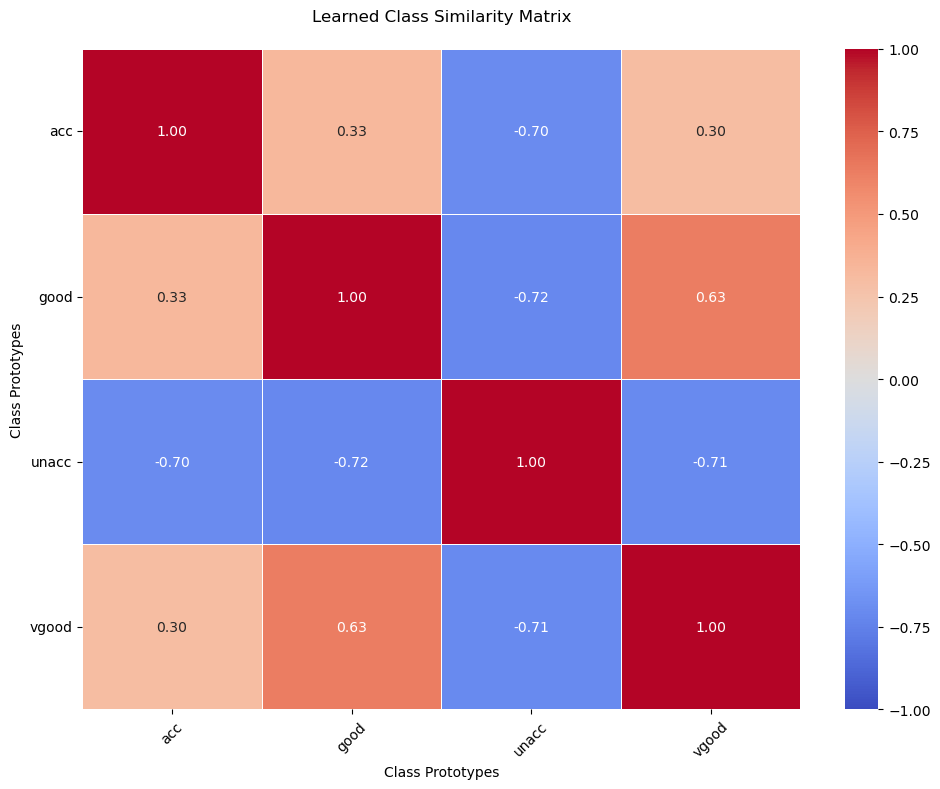

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

with torch.no_grad():
    prototypes = F.normalize(model.prototypes, p=2, dim=-1)
    
    sim_matrix = torch.mm(prototypes, prototypes.t()).numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            linewidths=0.5)

plt.title("Learned Class Similarity Matrix", pad=20)
plt.xlabel("Class Prototypes")
plt.ylabel("Class Prototypes")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()